In [1]:
RESULT = {'No': '066'}
FOLD = 'StratifiedKFold(neighbourhood)'

BASE_DATE = '2015-05-01'

N_SPLITS = 5

In [2]:
from copy import deepcopy
from dataclasses import dataclass
from functools import partial
import gc
import json
import os
from typing import List, Tuple, Optional, Callable

from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

import sys

# このフォルダがプロジェクトのルートディレクトリ
PATH = os.path.join(os.path.expanduser('~'), 'probspace-minpaku-pricing')
if PATH not in sys.path:
    sys.path.append(PATH)

from scripts.data_cleansing import cleanse_name
from scripts.feature_engineering import LanguageWiseTokenizer, LocationClustering

%matplotlib inline

In [3]:
pd.options.display.max_rows = pd.options.display.max_columns = 500
pd.options.display.float_format = '{:.3f}'.format

In [4]:
# ここにコンペのデータを突っ込んだ
INPUT_DIR = os.path.join(os.path.expanduser('~'), 'dataset', 'probspace', 'minpaku-pricing')
assert os.path.isdir(INPUT_DIR)

In [5]:
# ここに出力ファイルを保存する
OUTPUT_DIR = RESULT['No'] 
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [6]:
# 再現性確保のため交差検証の各 Fold の値は外部ファイルに保存してある
FOLD_DIR = os.path.join('..', 'folds')
assert os.path.isdir(FOLD_DIR)
FOLD_FILEPATH = os.path.join(FOLD_DIR, f'{FOLD}.csv')

In [7]:
# 再計算に時間がかかる特徴量を保存するフォルダ
FEATURES_DIR = os.path.join('..', 'features')
assert os.path.isdir(FEATURES_DIR)

## データの読み込み

In [8]:
train = pd.read_csv(os.path.join(INPUT_DIR, 'train_data.csv'), parse_dates=['last_review'])
train['y'] = train['y'].apply(np.log1p)

In [9]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_data.csv'), parse_dates=['last_review'])

In [10]:
# index は training/test を通じて一意な方が後続の特徴エンジニアリングで便利
train.index = list(range(train.shape[0]))
test.index = list(range(train.index.max() + 1, test.shape[0] + train.index.max() + 1))
assert set(train.index.tolist()) & set(test.index.tolist()) == set()

In [11]:
train

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,y
0,1,KiyosumiShirakawa 3min|★SkyTree★|WIFI|Max4|Tre...,242899459,Koto Ku,35.682,139.803,Entire home/apt,1,55,2020-04-25,2.210,173,9.393
1,2,Downtown Tokyo Iriya next to Ueno,308879948,Taito Ku,35.721,139.785,Entire home/apt,6,72,2020-03-25,2.110,9,8.805
2,3,"Japan Style,Private,Affordable,4min to Sta.",300877823,Katsushika Ku,35.747,139.823,Entire home/apt,1,18,2020-03-23,3.460,288,9.203
3,4,4 min to Shinjuku Sta. by train / 2 ppl / Wi-fi,236935461,Shibuya Ku,35.685,139.681,Entire home/apt,1,2,2020-04-02,1.760,87,9.001
4,5,LICENSED SHINJUKU HOUSE: Heart of the action!,243408889,Shinjuku Ku,35.698,139.705,Entire home/apt,1,86,2020-01-30,2.000,156,11.517
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,9986,Shinjuku Kabukicho2 / Shinjuku 3min walk,59104733,Shinjuku Ku,35.697,139.703,Entire home/apt,1,1,2019-12-09,0.210,357,9.511
9986,9987,Hostel just 1 min from Sta. / Dorm with curtain,131595566,Taito Ku,35.704,139.792,Shared room,1,0,NaT,NaN,153,8.096
9987,9988,Hostel just 5 min from Sta./4 bed room with bath,147026065,Taito Ku,35.715,139.794,Private room,1,5,2019-12-10,0.220,156,9.609
9988,9989,SHITARA HOUSE dormitory B,316273494,Katsushika Ku,35.747,139.829,Shared room,1,1,2020-01-01,0.250,0,8.282


In [12]:
test

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365
9990,1,"5-minute walk from Akasaka Sta, Superior double",184730720,Minato Ku,35.671,139.733,Private room,1,0,NaT,NaN,183
9991,2,7 min Sta.-Center of IKEBUKURO Cozy Room#503,20993205,Toshima Ku,35.730,139.717,Entire home/apt,2,21,2020-04-16,1.940,337
9992,3,Designer'sApt 1min sta☆Shinjuku 7min☆Shibuya 4min,322521715,Setagaya Ku,35.662,139.665,Entire home/apt,1,14,2020-02-12,0.820,240
9993,4,Komagome Station 2 minutes on foot,234477095,Toshima Ku,35.736,139.748,Entire home/apt,1,16,2020-02-17,1.190,0
9994,5,"Monthly/Metro1min/JR5min/Ueno,Asakusa,Akihabara",145453833,Taito Ku,35.721,139.783,Entire home/apt,30,2,2019-07-21,0.190,164
...,...,...,...,...,...,...,...,...,...,...,...,...
14981,4992,Stylish Pad In Nishi Shinjuku - Free WiFi!,166712541,Shibuya Ku,35.686,139.680,Entire home/apt,2,31,2019-12-15,1.600,174
14982,4993,U-6 鶯谷 BasaeInn Uguisudani Tokyo,58261300,Taito Ku,35.725,139.777,Shared room,2,6,2018-08-25,0.270,90
14983,4994,A convenient room! 〜SHINJUKU〜 【Pocket WiFi】,243229864,Shinjuku Ku,35.691,139.706,Entire home/apt,1,12,2020-03-14,2.540,113
14984,4995,Shinjuku ShareHouse Dormitory1 with Balcony,50190468,Shinjuku Ku,35.698,139.704,Shared room,2,71,2020-01-01,0.960,273


In [13]:
stations = pd.read_csv(os.path.join(INPUT_DIR, 'station_list.csv'))

In [14]:
stations = stations[stations['station_name'] != '押上〈スカイツリー前〉'].copy()
stations

,station_name,longitude,latitude
0,白丸,139.115,35.812
1,古里,139.152,35.816
2,川井,139.164,35.814
3,御嶽,139.183,35.801
4,沢井,139.193,35.806
...,...,...,...
740,明治神宮前〈原宿〉,139.705,35.668
741,とうきょうスカイツリー,139.809,35.710
743,押上（スカイツリー前）,139.813,35.711
744,南町田グランベリーパーク,139.470,35.512


## 特徴量エンジニアリング

### `last_review`

In [15]:
train['last_review'].min(), test['last_review'].min()

(Timestamp('2016-11-19 00:00:00'), Timestamp('2015-05-25 00:00:00'))

In [16]:
train['days_lapsed'] = (train['last_review'] - pd.Timestamp(BASE_DATE)).dt.days
test['days_lapsed'] = (test['last_review'] - pd.Timestamp(BASE_DATE)).dt.days

In [17]:
train

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,y,days_lapsed
0,1,KiyosumiShirakawa 3min|★SkyTree★|WIFI|Max4|Tre...,242899459,Koto Ku,35.682,139.803,Entire home/apt,1,55,2020-04-25,2.210,173,9.393,1821.000
1,2,Downtown Tokyo Iriya next to Ueno,308879948,Taito Ku,35.721,139.785,Entire home/apt,6,72,2020-03-25,2.110,9,8.805,1790.000
2,3,"Japan Style,Private,Affordable,4min to Sta.",300877823,Katsushika Ku,35.747,139.823,Entire home/apt,1,18,2020-03-23,3.460,288,9.203,1788.000
3,4,4 min to Shinjuku Sta. by train / 2 ppl / Wi-fi,236935461,Shibuya Ku,35.685,139.681,Entire home/apt,1,2,2020-04-02,1.760,87,9.001,1798.000
4,5,LICENSED SHINJUKU HOUSE: Heart of the action!,243408889,Shinjuku Ku,35.698,139.705,Entire home/apt,1,86,2020-01-30,2.000,156,11.517,1735.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,9986,Shinjuku Kabukicho2 / Shinjuku 3min walk,59104733,Shinjuku Ku,35.697,139.703,Entire home/apt,1,1,2019-12-09,0.210,357,9.511,1683.000
9986,9987,Hostel just 1 min from Sta. / Dorm with curtain,131595566,Taito Ku,35.704,139.792,Shared room,1,0,NaT,NaN,153,8.096,NaN
9987,9988,Hostel just 5 min from Sta./4 bed room with bath,147026065,Taito Ku,35.715,139.794,Private room,1,5,2019-12-10,0.220,156,9.609,1684.000
9988,9989,SHITARA HOUSE dormitory B,316273494,Katsushika Ku,35.747,139.829,Shared room,1,1,2020-01-01,0.250,0,8.282,1706.000


In [18]:
test

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,days_lapsed
9990,1,"5-minute walk from Akasaka Sta, Superior double",184730720,Minato Ku,35.671,139.733,Private room,1,0,NaT,NaN,183,NaN
9991,2,7 min Sta.-Center of IKEBUKURO Cozy Room#503,20993205,Toshima Ku,35.730,139.717,Entire home/apt,2,21,2020-04-16,1.940,337,1812.000
9992,3,Designer'sApt 1min sta☆Shinjuku 7min☆Shibuya 4min,322521715,Setagaya Ku,35.662,139.665,Entire home/apt,1,14,2020-02-12,0.820,240,1748.000
9993,4,Komagome Station 2 minutes on foot,234477095,Toshima Ku,35.736,139.748,Entire home/apt,1,16,2020-02-17,1.190,0,1753.000
9994,5,"Monthly/Metro1min/JR5min/Ueno,Asakusa,Akihabara",145453833,Taito Ku,35.721,139.783,Entire home/apt,30,2,2019-07-21,0.190,164,1542.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14981,4992,Stylish Pad In Nishi Shinjuku - Free WiFi!,166712541,Shibuya Ku,35.686,139.680,Entire home/apt,2,31,2019-12-15,1.600,174,1689.000
14982,4993,U-6 鶯谷 BasaeInn Uguisudani Tokyo,58261300,Taito Ku,35.725,139.777,Shared room,2,6,2018-08-25,0.270,90,1212.000
14983,4994,A convenient room! 〜SHINJUKU〜 【Pocket WiFi】,243229864,Shinjuku Ku,35.691,139.706,Entire home/apt,1,12,2020-03-14,2.540,113,1779.000
14984,4995,Shinjuku ShareHouse Dormitory1 with Balcony,50190468,Shinjuku Ku,35.698,139.704,Shared room,2,71,2020-01-01,0.960,273,1706.000


In [19]:
train.drop(columns=['last_review'], inplace=True)
test.drop(columns=['last_review'], inplace=True)

### `reviews_per_month`

In [20]:
train['reviews_per_month'].fillna(-1, inplace=True)
test['reviews_per_month'].fillna(-1, inplace=True)

### `name`

#### Vectorization

In [21]:
train['name'] = train['name'].apply(cleanse_name)
test['name'] = test['name'].apply(cleanse_name)

In [22]:
%%time
tokenizer = LanguageWiseTokenizer(language_detection_model_path=os.path.join(os.path.expanduser('~'), 'models', 'fasttext', 'lid.176.bin'))
train['name'] = tokenizer.transform(train['name'])
test['name'] = tokenizer.transform(test['name'])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\NNDROP~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.738 seconds.
Prefix dict has been built successfully.


CPU times: total: 1.2 s
Wall time: 1.66 s


In [23]:
n_components = 64

In [24]:
%%time
vectorizers = {
    'nmf': Pipeline(
        steps=[
            ('tfidf', TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')),
            ('nmf', NMF(n_components=n_components, random_state=1911, shuffle=True))
        ]
    ),
    'lsi': Pipeline(
        steps=[
            ('tfidf', TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')),
            ('lsi', TruncatedSVD(n_components=n_components, random_state=3014))
        ]
    )
}

CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
for name, vectorizer in vectorizers.items():
    vec_train = vectorizer.fit_transform(train['name'])
    columns = [f'{name}_vec{i + 1}' for i in range(vec_train.shape[1])]
    vec_train = pd.DataFrame(data=vec_train, columns=columns, index=train.index)
    train = pd.concat([train, vec_train], axis=1)

    vec_test = vectorizer.transform(test['name'])
    vec_test = pd.DataFrame(data=vec_test, columns=columns, index=test.index)
    test = pd.concat([test, vec_test], axis=1)

C:\Users\nndropout\probspace-minpaku-pricing\.venv\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\nndropout\probspace-minpaku-pricing\.venv\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [26]:
train

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365,y,days_lapsed,nmf_vec1,nmf_vec2,nmf_vec3,nmf_vec4,nmf_vec5,nmf_vec6,nmf_vec7,nmf_vec8,nmf_vec9,nmf_vec10,nmf_vec11,nmf_vec12,nmf_vec13,nmf_vec14,nmf_vec15,nmf_vec16,nmf_vec17,nmf_vec18,nmf_vec19,nmf_vec20,nmf_vec21,nmf_vec22,nmf_vec23,nmf_vec24,nmf_vec25,nmf_vec26,nmf_vec27,nmf_vec28,nmf_vec29,nmf_vec30,nmf_vec31,nmf_vec32,nmf_vec33,nmf_vec34,nmf_vec35,nmf_vec36,nmf_vec37,nmf_vec38,nmf_vec39,nmf_vec40,nmf_vec41,nmf_vec42,nmf_vec43,nmf_vec44,nmf_vec45,nmf_vec46,nmf_vec47,nmf_vec48,nmf_vec49,nmf_vec50,nmf_vec51,nmf_vec52,nmf_vec53,nmf_vec54,nmf_vec55,nmf_vec56,nmf_vec57,nmf_vec58,nmf_vec59,nmf_vec60,nmf_vec61,nmf_vec62,nmf_vec63,nmf_vec64,lsi_vec1,lsi_vec2,lsi_vec3,lsi_vec4,lsi_vec5,lsi_vec6,lsi_vec7,lsi_vec8,lsi_vec9,lsi_vec10,lsi_vec11,lsi_vec12,lsi_vec13,lsi_vec14,lsi_vec15,lsi_vec16,lsi_vec17,lsi_vec18,lsi_vec19,lsi_vec20,lsi_vec21,lsi_vec22,lsi_vec23,lsi_vec24,lsi_vec25,lsi_vec26,lsi_vec27,lsi_vec28,lsi_vec29,lsi_vec30,lsi_vec31,lsi_vec32,lsi_vec33,lsi_vec34,lsi_vec35,lsi_vec36,lsi_vec37,lsi_vec38,lsi_vec39,lsi_vec40,lsi_vec41,lsi_vec42,lsi_vec43,lsi_vec44,lsi_vec45,lsi_vec46,lsi_vec47,lsi_vec48,lsi_vec49,lsi_vec50,lsi_vec51,lsi_vec52,lsi_vec53,lsi_vec54,lsi_vec55,lsi_vec56,lsi_vec57,lsi_vec58,lsi_vec59,lsi_vec60,lsi_vec61,lsi_vec62,lsi_vec63,lsi_vec64
0,1,kiyosumishirakawa 3min skytree wifi max4 tree102,242899459,Koto Ku,35.682,139.803,Entire home/apt,1,55,2.210,173,9.393,1821.000,0.000,0.000,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.070,0.000,0.002,0.001,0.000,0.000,0.000,0.000,0.003,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.093,-0.032,0.002,0.100,-0.026,-0.000,-0.050,-0.058,0.034,-0.060,-0.010,0.007,-0.002,-0.006,0.068,-0.028,0.003,-0.015,-0.008,0.044,0.058,0.032,-0.033,0.005,-0.003,-0.075,0.015,0.032,0.086,-0.016,0.012,-0.023,-0.042,0.037,0.007,-0.019,0.009,-0.017,0.149,-0.062,0.066,0.068,0.054,0.016,-0.008,-0.011,-0.110,-0.039,-0.038,-0.040,-0.049,-0.018,0.037,0.000,-0.006,0.014,0.001,-0.013,-0.014,-0.053,0.014,0.026,-0.012,0.014
1,2,downtown tokyo iriya next to ueno,308879948,Taito Ku,35.721,139.785,Entire home/apt,6,72,2.110,9,8.805,1790.000,0.014,0.000,0.000,0.002,0.001,0.000,0.000,0.000,0.000,0.083,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.003,0.000,0.002,0.000,0.000,0.002,0.000,0.001,0.000,0.000,0.000,0.025,0.000,0.000,0.003,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.147,0.107,-0.131,0.085,0.032,-0.056,0.101,0.087,-0.053,-0.068,-0.049,0.016,0.022,0.060,-0.034,0.037,-0.085,0.059,0.004,0.008,0.019,-0.078,0.030,-0.055,-0.044,-0.032,-0.017,-0.036,0.001,0.016,-0.061,0.027,0.084,-0.044,-0.015,0.058,-0.080,-0.030,-0.003,-0.040,-0.042,0.079,0.042,-0.010,-0.048,-0.114,0.013,0.030,-0.019,0.005,0.039,0.006,-0.041,0.043,0.015,-0.001,-0.006,0.011,0.003,0.048,-0.020,-0.002,-0.012,-0.040
2,3,japan style private affordable 4min to sta.,300877823,Katsushika Ku,35.747,139.823,Entire home/apt,1,18,3.460,288,9.203,1788.000,0.014,0.000,0.000,0.000,0.002,0.000,0.000,0.056,0.000,0.004,0.000,0.062,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.063,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.179,0.049,-0.010,0.004,0.078,-0.150,0.076,-0.043,-0.027,0.053,0.058,0.149,-0.055,-0.092,0.029,-0.032,-0.046,-0.063,-0.005,-0.043,0.067,-0.031,0.011,0.062,0.009,0.061,0.032,-0.007,-0.060,-0.075,-0.066,0.063,-0.016,0.001,-0.080,-

In [27]:
test

,id,name,host_id,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365,days_lapsed,nmf_vec1,nmf_vec2,nmf_vec3,nmf_vec4,nmf_vec5,nmf_vec6,nmf_vec7,nmf_vec8,nmf_vec9,nmf_vec10,nmf_vec11,nmf_vec12,nmf_vec13,nmf_vec14,nmf_vec15,nmf_vec16,nmf_vec17,nmf_vec18,nmf_vec19,nmf_vec20,nmf_vec21,nmf_vec22,nmf_vec23,nmf_vec24,nmf_vec25,nmf_vec26,nmf_vec27,nmf_vec28,nmf_vec29,nmf_vec30,nmf_vec31,nmf_vec32,nmf_vec33,nmf_vec34,nmf_vec35,nmf_vec36,nmf_vec37,nmf_vec38,nmf_vec39,nmf_vec40,nmf_vec41,nmf_vec42,nmf_vec43,nmf_vec44,nmf_vec45,nmf_vec46,nmf_vec47,nmf_vec48,nmf_vec49,nmf_vec50,nmf_vec51,nmf_vec52,nmf_vec53,nmf_vec54,nmf_vec55,nmf_vec56,nmf_vec57,nmf_vec58,nmf_vec59,nmf_vec60,nmf_vec61,nmf_vec62,nmf_vec63,nmf_vec64,lsi_vec1,lsi_vec2,lsi_vec3,lsi_vec4,lsi_vec5,lsi_vec6,lsi_vec7,lsi_vec8,lsi_vec9,lsi_vec10,lsi_vec11,lsi_vec12,lsi_vec13,lsi_vec14,lsi_vec15,lsi_vec16,lsi_vec17,lsi_vec18,lsi_vec19,lsi_vec20,lsi_vec21,lsi_vec22,lsi_vec23,lsi_vec24,lsi_vec25,lsi_vec26,lsi_vec27,lsi_vec28,lsi_vec29,lsi_vec30,lsi_vec31,lsi_vec32,lsi_vec33,lsi_vec34,lsi_vec35,lsi_vec36,lsi_vec37,lsi_vec38,lsi_vec39,lsi_vec40,lsi_vec41,lsi_vec42,lsi_vec43,lsi_vec44,lsi_vec45,lsi_vec46,lsi_vec47,lsi_vec48,lsi_vec49,lsi_vec50,lsi_vec51,lsi_vec52,lsi_vec53,lsi_vec54,lsi_vec55,lsi_vec56,lsi_vec57,lsi_vec58,lsi_vec59,lsi_vec60,lsi_vec61,lsi_vec62,lsi_vec63,lsi_vec64
9990,1,5-minute walk from akasaka sta superior double,184730720,Minato Ku,35.671,139.733,Private room,1,0,-1.000,183,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.003,0.000,0.000,0.018,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.035,0.000,0.000,0.000,0.000,0.000,0.186,-0.026,-0.096,-0.159,-0.101,-0.160,-0.081,-0.245,0.070,-0.058,-0.027,0.057,0.025,0.085,-0.010,-0.065,-0.028,0.023,0.114,0.020,-0.024,-0.047,0.002,0.041,-0.020,-0.023,-0.078,-0.111,0.093,-0.039,0.106,-0.010,-0.083,0.006,-0.172,0.017,0.095,-0.085,0.053,-0.025,-0.068,0.048,0.021,0.007,0.070,0.095,0.098,0.045,-0.003,-0.047,0.064,-0.057,-0.012,0.008,-0.028,0.001,-0.001,0.056,-0.044,0.047,0.038,0.028,0.044,-0.044
9991,2,7 min sta.-center of ikebukuro cozy room 503,20993205,Toshima Ku,35.730,139.717,Entire home/apt,2,21,1.940,337,1812.000,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.049,0.024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.084,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.052,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.068,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.145,0.000,0.000,0.249,0.172,0.039,-0.168,0.064,-0.083,0.126,-0.097,0.076,0.014,-0.128,-0.063,-0.171,0.004,0.049,-0.070,0.140,-0.005,-0.136,0.106,-0.055,-0.061,-0.035,-0.041,0.053,-0.065,0.029,-0.015,-0.016,0.014,-0.039,-0.044,-0.013,-0.020,0.028,0.035,0.141,-0.034,-0.089,0.108,0.037,-0.032,-0.054,-0.089,-0.042,-0.005,-0.111,-0.033,0.121,-0.122,0.115,-0.033,-0.073,0.033,0.119,-0.027,0.036,-0.001,0.059,-0.141,-0.150,0.096,-0.081,0.108
9992,3,designer sapt 1min sta shinjuku 7min shibuya 4min,322521715,Setagaya Ku,35.662,139.665,Entire home/apt,1,14,0.820,240,1748.000,0.001,0.000,0.000,0.000,0.002,0.000,0.000,0.064,0.000,0.000,0.044,0.000,0.000,0.000,0.001,0.000,0.047,0.010,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.005,0.002,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.228,-0.062,-0.024,-0.076,0.248,-0.039,0.001,-0.115,0.008,-0.005,0.200,-0.024,0.035,-0.033,-0.021,0.035,-0.046,-0.020,-0.017,-0.057,0.050,0.100,-0.027,0.008,-0.008,-0.000,-0.086,-0.073,0.005,-0.085,0.196,-0.056,0.093,-0.069,0

In [28]:
del vectorizers
gc.collect()

4

#### Mask

In [29]:
# train/test の両方に存在するもの以外は適当な名称でマスク
_NAME = '__NO_DATA_NAME'
assert _NAME not in train['name'].tolist()
assert _NAME not in test['name'].tolist()
name_shared = set(train['name'].tolist()) & set(test['name'].tolist())
train['name'] = train['name'].apply(lambda x: x if x in name_shared else _NAME)
test['name'] = test['name'].apply(lambda x: x if x in name_shared else _NAME)

### `latitude`, `longitude`

In [30]:
location_columns = ['latitude', 'longitude']
locations_train = train[location_columns].copy()
locations_test = test[location_columns].copy()
locations = pd.concat([locations_train, locations_test], axis=0)
assert not locations.index.duplicated().any()

In [31]:
kmeans = LocationClustering({'n_clusters': 9, 'random_state': 910}).fit(locations)
location_clustering_features = kmeans.transform(locations)
location_clustering_features

,cluster_id,km_from_center,azimuth
0,7,2.539,206.129
1,1,0.577,13.153
2,4,2.284,276.850
3,6,2.145,231.242
4,6,0.527,68.572
...,...,...,...
14981,6,2.123,234.502
14982,1,1.200,330.652
14983,6,0.884,135.112
14984,6,0.504,66.429


In [32]:
for c in location_clustering_features.columns:
    train[c] = location_clustering_features.loc[train.index, c]
    test[c] = location_clustering_features.loc[test.index, c]

## 特徴選択

In [33]:
# 特徴量を列挙する
features = [c for c in train.columns if c not in ('id', 'host_id', 'y')]
features

['name',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'availability_365',
 'days_lapsed',
 'nmf_vec1',
 'nmf_vec2',
 'nmf_vec3',
 'nmf_vec4',
 'nmf_vec5',
 'nmf_vec6',
 'nmf_vec7',
 'nmf_vec8',
 'nmf_vec9',
 'nmf_vec10',
 'nmf_vec11',
 'nmf_vec12',
 'nmf_vec13',
 'nmf_vec14',
 'nmf_vec15',
 'nmf_vec16',
 'nmf_vec17',
 'nmf_vec18',
 'nmf_vec19',
 'nmf_vec20',
 'nmf_vec21',
 'nmf_vec22',
 'nmf_vec23',
 'nmf_vec24',
 'nmf_vec25',
 'nmf_vec26',
 'nmf_vec27',
 'nmf_vec28',
 'nmf_vec29',
 'nmf_vec30',
 'nmf_vec31',
 'nmf_vec32',
 'nmf_vec33',
 'nmf_vec34',
 'nmf_vec35',
 'nmf_vec36',
 'nmf_vec37',
 'nmf_vec38',
 'nmf_vec39',
 'nmf_vec40',
 'nmf_vec41',
 'nmf_vec42',
 'nmf_vec43',
 'nmf_vec44',
 'nmf_vec45',
 'nmf_vec46',
 'nmf_vec47',
 'nmf_vec48',
 'nmf_vec49',
 'nmf_vec50',
 'nmf_vec51',
 'nmf_vec52',
 'nmf_vec53',
 'nmf_vec54',
 'nmf_vec55',
 'nmf_vec56',
 'nmf_vec57',
 'nmf_vec58',
 'nmf_vec59',
 'nmf_vec60',
 

In [34]:
# カテゴリとして扱う特徴量を列挙する
cat_features = ['name', 'neighbourhood', 'room_type', 'cluster_id']
cat_features

['name', 'neighbourhood', 'room_type', 'cluster_id']

In [35]:
assert set(cat_features) - set(features) == set()

## 交差検証

In [36]:
train = train.sort_values('id')

In [37]:
# Fold は保存して使いまわす！
split_indice : List[Tuple[np.ndarray, np.ndarray]] = []
if os.path.isfile(FOLD_FILEPATH):
    print(f'{FOLD_FILEPATH} exists.')
    fold = pd.read_csv(FOLD_FILEPATH)
    for i in np.sort(fold['fold'].unique()):
        ids_train = fold[(fold['fold'] == i) & (fold['training_fold'])]['id']
        idx_train = train[train['id'].isin(ids_train)].index
        ids_valid = fold[(fold['fold'] == i) & (~fold['training_fold'])]['id']
        idx_valid = train[train['id'].isin(ids_valid)].index
        split_indice.append((idx_train, idx_valid))
else:
    from sklearn.model_selection import GroupKFold
    fold = []
    splitter = GroupKFold(n_splits=N_SPLITS)
    for i, (idx_train, idx_valid) in enumerate(splitter.split(train[features], train['y'], train['host_id'])):
        split_indice.append((idx_train, idx_valid))
        
        # Save
        fold_train = pd.DataFrame()
        fold_train['id'] = train.iloc[idx_train]['id']
        fold_train['training_fold'] = True
        fold_train['fold'] = i
        fold_valid = pd.DataFrame()
        fold_valid['id'] = train.iloc[idx_valid]['id']
        fold_valid['training_fold'] = False
        fold_valid['fold'] = i
        fold.append(pd.concat([fold_train, fold_valid]))
    fold = pd.concat(fold)
    fold.to_csv(FOLD_FILEPATH, index=False)
    del fold, fold_train, fold_valid

..\folds\StratifiedKFold(neighbourhood).csv exists.


In [38]:
@dataclass
class CrossValidationResult:
    '''Cross validation result.
    
    Attributes
    ----------
    prediction_train, prediction_valid, prediction_test: pd.DataFrame
        Prediction for training/validation/test set, having following 3 columns;
        - `PassengerId`
        - `Fold`
        - `Prediction`.
        `Fold` is identifier of number of cross validation loop, starting from 1.
        `Prediction` is predicted value of `Transported`.
    scores: pd.DataFrame
        Accuracy scores of each cv loop having following 2 columns;
        - `Training`
        - `Validation`.
    classifiers: list
        Fitted classifiers.
    '''
    
    prediction_train: pd.DataFrame
    prediction_valid: pd.DataFrame
    prediction_test: pd.DataFrame
    scores: pd.DataFrame
    classifiers: list
        
    @property
    def local_cv(self) -> float:
        return self.scores['Validation'].mean()

In [39]:
def run_cross_validation_v2(
    train: pd.DataFrame,
    test: pd.DataFrame,
    fold_indice: List[Tuple[np.ndarray, np.ndarray]],
    features : List[str],
    base_classifier,
    metric_fn: Callable,
    fit_params: Optional[dict] = None,
    y : str = 'y',
    row_id : str = 'id') -> CrossValidationResult:
    '''Run cross validation.
    
    Parameters
    ----------
    train, test: pd.DataFrame
        Training set and test set.
    fold_indice: type_fold_indice
        List of indice which split given training data into training/validation set in each fold.
    features : List[str]
        List of features' name.
    base_classifier
        Scikit-learn like object.
    metric_fn : Callable
    fit_params: Optional[dict]
        If given, it will be used when fitting classifier like `classifier.fit(X, y, **fit_params`).
    y : str
        Target column name.
    row_id : str
        Column name of row identifier.

    Returns
    -------
    cv_result : CrossValidationResult
    
    '''
    prediction_train = []
    prediction_valid = []
    prediction_test = []
    scores = []
    classifiers = []

    for i, (idx_train, idx_valid) in enumerate(fold_indice):
        X_train = train.iloc[idx_train][features].copy()
        y_train = train.iloc[idx_train][y].copy()
        X_valid = train.iloc[idx_valid][features].copy()
        y_valid = train.iloc[idx_valid][y].copy()
        X_test = test[features].copy()
    
        # Train classifier
        classifier = deepcopy(base_classifier)
        if fit_params:
            classifier.fit(X_train, y_train, **fit_params)
        else:
            classifier.fit(X_train, y_train)
        classifier.feature_names__ = X_train.columns.tolist()
        classifiers.append(classifier)
    
        # Make prediction
        #- Training set
        pred_train = np.clip(classifier.predict(X_train), 0., None)
        prediction_train_ = pd.DataFrame()
        prediction_train_[row_id] = train.iloc[idx_train][row_id]
        prediction_train_['Prediction'] = pred_train
        prediction_train_['Fold'] = i + 1
        prediction_train.append(prediction_train_)
        #- Validation set
        pred_valid = np.clip(classifier.predict(X_valid), 0., None)
        prediction_valid_ = pd.DataFrame()
        prediction_valid_[row_id] = train.iloc[idx_valid][row_id]
        prediction_valid_['Prediction'] = pred_valid
        prediction_valid_['Fold'] = i + 1
        prediction_valid.append(prediction_valid_)
        #- Test set
        prediction_test_ = pd.DataFrame()
        prediction_test_[row_id] = test[row_id]
        prediction_test_['Prediction'] = np.clip(classifier.predict(X_test), 0., None)
        prediction_test_['Fold'] = i + 1
        prediction_test.append(prediction_test_)
        del prediction_train_, prediction_valid_, prediction_test_
        # Scoring
        score_train = metric_fn(y_train, pred_train)
        score_valid = metric_fn(y_valid, pred_valid)
        print(f'Fold {i + 1}...Training score: {score_train}, Validation score: {score_valid}')
        scores.append([score_train, score_valid])

    scores = pd.DataFrame(scores, columns=['Training', 'Validation'])
    prediction_train = pd.concat(prediction_train)
    prediction_valid = pd.concat(prediction_valid)
    prediction_test = pd.concat(prediction_test)
    cv_result = CrossValidationResult(
        prediction_train,
        prediction_valid,
        prediction_test,
        scores,
        classifiers
    )
    return cv_result

In [40]:
%%time
train_dir = os.path.join(RESULT['No'], 'catboost')
base_estimator = CatBoostRegressor(random_state=1, cat_features=cat_features, train_dir=train_dir, loss_function='RMSE')
metric_fn = partial(mean_squared_error, squared=False)
result = run_cross_validation_v2(train, test, split_indice, features, base_estimator, metric_fn)
RESULT['CV'] = result.local_cv

Learning rate set to 0.056859
0:	learn: 0.9695051	total: 214ms	remaining: 3m 33s
1:	learn: 0.9574725	total: 250ms	remaining: 2m 4s
2:	learn: 0.9469659	total: 282ms	remaining: 1m 33s
3:	learn: 0.9364763	total: 313ms	remaining: 1m 17s
4:	learn: 0.9276796	total: 347ms	remaining: 1m 9s
5:	learn: 0.9186893	total: 384ms	remaining: 1m 3s
6:	learn: 0.9094018	total: 419ms	remaining: 59.5s
7:	learn: 0.9015905	total: 453ms	remaining: 56.2s
8:	learn: 0.8942951	total: 488ms	remaining: 53.7s
9:	learn: 0.8877722	total: 523ms	remaining: 51.8s
10:	learn: 0.8806894	total: 568ms	remaining: 51.1s
11:	learn: 0.8757071	total: 619ms	remaining: 50.9s
12:	learn: 0.8707322	total: 665ms	remaining: 50.5s
13:	learn: 0.8661498	total: 729ms	remaining: 51.4s
14:	learn: 0.8620520	total: 771ms	remaining: 50.6s
15:	learn: 0.8562776	total: 810ms	remaining: 49.8s
16:	learn: 0.8516974	total: 863ms	remaining: 49.9s
17:	learn: 0.8474934	total: 914ms	remaining: 49.9s
18:	learn: 0.8431546	total: 968ms	remaining: 50s
19:	learn:

,name,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365,days_lapsed,nmf_vec1,nmf_vec2,nmf_vec3,nmf_vec4,nmf_vec5,nmf_vec6,nmf_vec7,nmf_vec8,nmf_vec9,nmf_vec10,nmf_vec11,nmf_vec12,nmf_vec13,nmf_vec14,nmf_vec15,nmf_vec16,nmf_vec17,nmf_vec18,nmf_vec19,nmf_vec20,nmf_vec21,nmf_vec22,nmf_vec23,nmf_vec24,nmf_vec25,nmf_vec26,nmf_vec27,nmf_vec28,nmf_vec29,nmf_vec30,nmf_vec31,nmf_vec32,nmf_vec33,nmf_vec34,nmf_vec35,nmf_vec36,nmf_vec37,nmf_vec38,nmf_vec39,nmf_vec40,nmf_vec41,nmf_vec42,nmf_vec43,nmf_vec44,nmf_vec45,nmf_vec46,nmf_vec47,nmf_vec48,nmf_vec49,nmf_vec50,nmf_vec51,nmf_vec52,nmf_vec53,nmf_vec54,nmf_vec55,nmf_vec56,nmf_vec57,nmf_vec58,nmf_vec59,nmf_vec60,nmf_vec61,nmf_vec62,nmf_vec63,nmf_vec64,lsi_vec1,lsi_vec2,lsi_vec3,lsi_vec4,lsi_vec5,lsi_vec6,lsi_vec7,lsi_vec8,lsi_vec9,lsi_vec10,lsi_vec11,lsi_vec12,lsi_vec13,lsi_vec14,lsi_vec15,lsi_vec16,lsi_vec17,lsi_vec18,lsi_vec19,lsi_vec20,lsi_vec21,lsi_vec22,lsi_vec23,lsi_vec24,lsi_vec25,lsi_vec26,lsi_vec27,lsi_vec28,lsi_vec29,lsi_vec30,lsi_vec31,lsi_vec32,lsi_vec33,lsi_vec34,lsi_vec35,lsi_vec36,lsi_vec37,lsi_vec38,lsi_vec39,lsi_vec40,lsi_vec41,lsi_vec42,lsi_vec43,lsi_vec44,lsi_vec45,lsi_vec46,lsi_vec47,lsi_vec48,lsi_vec49,lsi_vec50,lsi_vec51,lsi_vec52,lsi_vec53,lsi_vec54,lsi_vec55,lsi_vec56,lsi_vec57,lsi_vec58,lsi_vec59,lsi_vec60,lsi_vec61,lsi_vec62,lsi_vec63,lsi_vec64,cluster_id,km_from_center,azimuth
9990,__NO_DATA_NAME,Minato Ku,35.671,139.733,Private room,1,0,-1.000,183,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.003,0.000,0.000,0.018,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.035,0.000,0.000,0.000,0.000,0.000,0.186,-0.026,-0.096,-0.159,-0.101,-0.160,-0.081,-0.245,0.070,-0.058,-0.027,0.057,0.025,0.085,-0.010,-0.065,-0.028,0.023,0.114,0.020,-0.024,-0.047,0.002,0.041,-0.020,-0.023,-0.078,-0.111,0.093,-0.039,0.106,-0.010,-0.083,0.006,-0.172,0.017,0.095,-0.085,0.053,-0.025,-0.068,0.048,0.021,0.007,0.070,0.095,0.098,0.045,-0.003,-0.047,0.064,-0.057,-0.012,0.008,-0.028,0.001,-0.001,0.056,-0.044,0.047,0.038,0.028,0.044,-0.044,8,2.462,273.164
9991,__NO_DATA_NAME,Toshima Ku,35.730,139.717,Entire home/apt,2,21,1.940,337,1812.000,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.049,0.024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.084,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.052,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.068,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.145,0.000,0.000,0.249,0.172,0.039,-0.168,0.064,-0.083,0.126,-0.097,0.076,0.014,-0.128,-0.063,-0.171,0.004,0.049,-0.070,0.140,-0.005,-0.136,0.106,-0.055,-0.061,-0.035,-0.041,0.053,-0.065,0.029,-0.015,-0.016,0.014,-0.039,-0.044,-0.013,-0.020,0.028,0.035,0.141,-0.034,-0.089,0.108,0.037,-0.032,-0.054,-0.089,-0.042,-0.005,-0.111,-0.033,0.121,-0.122,0.115,-0.033,-0.073,0.033,0.119,-0.027,0.036,-0.001,0.059,-0.141,-0.150,0.096,-0.081,0.108,5,1.204,175.591
9992,__NO_DATA_NAME,Setagaya Ku,35.662,139.665,Entire home/apt,1,14,0.820,240,1748.000,0.001,0.000,0.000,0.000,0.002,0.000,0.000,0.064,0.000,0.000,0.044,0.000,0.000,0.000,0.001,0.000,0.047,0.010,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.005,0.002,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.228,-0.062,-0.024,-0.076,0.248,-0.039,0.001,-0.115,0.008,-0.005,0.200,-0.024,0.035,-0.033,-0.021,0.035,-0.046,-0.020,-0.017,-0.057,0.050,0.100,-0.027,0.008,-0.008,-0.000,-0.086,-0.073,0.005,-0.085,0.196,-0.056,0.093,-0.069,0.072,0.048,-0.079,-0.037,-0.100,-0.001,0.020,0.049,-0.079,0.082,-0.044,0.006,

Fold 1...Training score: 0.3411576529448197, Validation score: 0.5502287805180939
Learning rate set to 0.056859
0:	learn: 0.9642898	total: 39.1ms	remaining: 39s
1:	learn: 0.9526844	total: 72.4ms	remaining: 36.1s
2:	learn: 0.9412974	total: 105ms	remaining: 34.8s
3:	learn: 0.9326699	total: 137ms	remaining: 34s
4:	learn: 0.9236705	total: 168ms	remaining: 33.4s
5:	learn: 0.9161024	total: 200ms	remaining: 33.2s
6:	learn: 0.9083816	total: 231ms	remaining: 32.7s
7:	learn: 0.8997053	total: 261ms	remaining: 32.4s
8:	learn: 0.8938460	total: 293ms	remaining: 32.2s
9:	learn: 0.8872576	total: 335ms	remaining: 33.2s
10:	learn: 0.8817097	total: 375ms	remaining: 33.7s
11:	learn: 0.8766903	total: 461ms	remaining: 37.9s
12:	learn: 0.8699891	total: 526ms	remaining: 39.9s
13:	learn: 0.8651066	total: 556ms	remaining: 39.2s
14:	learn: 0.8595674	total: 587ms	remaining: 38.5s
15:	learn: 0.8548345	total: 618ms	remaining: 38s
16:	learn: 0.8500513	total: 650ms	remaining: 37.6s
17:	learn: 0.8464635	total: 680ms	r

,name,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365,days_lapsed,nmf_vec1,nmf_vec2,nmf_vec3,nmf_vec4,nmf_vec5,nmf_vec6,nmf_vec7,nmf_vec8,nmf_vec9,nmf_vec10,nmf_vec11,nmf_vec12,nmf_vec13,nmf_vec14,nmf_vec15,nmf_vec16,nmf_vec17,nmf_vec18,nmf_vec19,nmf_vec20,nmf_vec21,nmf_vec22,nmf_vec23,nmf_vec24,nmf_vec25,nmf_vec26,nmf_vec27,nmf_vec28,nmf_vec29,nmf_vec30,nmf_vec31,nmf_vec32,nmf_vec33,nmf_vec34,nmf_vec35,nmf_vec36,nmf_vec37,nmf_vec38,nmf_vec39,nmf_vec40,nmf_vec41,nmf_vec42,nmf_vec43,nmf_vec44,nmf_vec45,nmf_vec46,nmf_vec47,nmf_vec48,nmf_vec49,nmf_vec50,nmf_vec51,nmf_vec52,nmf_vec53,nmf_vec54,nmf_vec55,nmf_vec56,nmf_vec57,nmf_vec58,nmf_vec59,nmf_vec60,nmf_vec61,nmf_vec62,nmf_vec63,nmf_vec64,lsi_vec1,lsi_vec2,lsi_vec3,lsi_vec4,lsi_vec5,lsi_vec6,lsi_vec7,lsi_vec8,lsi_vec9,lsi_vec10,lsi_vec11,lsi_vec12,lsi_vec13,lsi_vec14,lsi_vec15,lsi_vec16,lsi_vec17,lsi_vec18,lsi_vec19,lsi_vec20,lsi_vec21,lsi_vec22,lsi_vec23,lsi_vec24,lsi_vec25,lsi_vec26,lsi_vec27,lsi_vec28,lsi_vec29,lsi_vec30,lsi_vec31,lsi_vec32,lsi_vec33,lsi_vec34,lsi_vec35,lsi_vec36,lsi_vec37,lsi_vec38,lsi_vec39,lsi_vec40,lsi_vec41,lsi_vec42,lsi_vec43,lsi_vec44,lsi_vec45,lsi_vec46,lsi_vec47,lsi_vec48,lsi_vec49,lsi_vec50,lsi_vec51,lsi_vec52,lsi_vec53,lsi_vec54,lsi_vec55,lsi_vec56,lsi_vec57,lsi_vec58,lsi_vec59,lsi_vec60,lsi_vec61,lsi_vec62,lsi_vec63,lsi_vec64,cluster_id,km_from_center,azimuth
9990,__NO_DATA_NAME,Minato Ku,35.671,139.733,Private room,1,0,-1.000,183,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.003,0.000,0.000,0.018,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.035,0.000,0.000,0.000,0.000,0.000,0.186,-0.026,-0.096,-0.159,-0.101,-0.160,-0.081,-0.245,0.070,-0.058,-0.027,0.057,0.025,0.085,-0.010,-0.065,-0.028,0.023,0.114,0.020,-0.024,-0.047,0.002,0.041,-0.020,-0.023,-0.078,-0.111,0.093,-0.039,0.106,-0.010,-0.083,0.006,-0.172,0.017,0.095,-0.085,0.053,-0.025,-0.068,0.048,0.021,0.007,0.070,0.095,0.098,0.045,-0.003,-0.047,0.064,-0.057,-0.012,0.008,-0.028,0.001,-0.001,0.056,-0.044,0.047,0.038,0.028,0.044,-0.044,8,2.462,273.164
9991,__NO_DATA_NAME,Toshima Ku,35.730,139.717,Entire home/apt,2,21,1.940,337,1812.000,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.049,0.024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.084,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.052,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.068,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.145,0.000,0.000,0.249,0.172,0.039,-0.168,0.064,-0.083,0.126,-0.097,0.076,0.014,-0.128,-0.063,-0.171,0.004,0.049,-0.070,0.140,-0.005,-0.136,0.106,-0.055,-0.061,-0.035,-0.041,0.053,-0.065,0.029,-0.015,-0.016,0.014,-0.039,-0.044,-0.013,-0.020,0.028,0.035,0.141,-0.034,-0.089,0.108,0.037,-0.032,-0.054,-0.089,-0.042,-0.005,-0.111,-0.033,0.121,-0.122,0.115,-0.033,-0.073,0.033,0.119,-0.027,0.036,-0.001,0.059,-0.141,-0.150,0.096,-0.081,0.108,5,1.204,175.591
9992,__NO_DATA_NAME,Setagaya Ku,35.662,139.665,Entire home/apt,1,14,0.820,240,1748.000,0.001,0.000,0.000,0.000,0.002,0.000,0.000,0.064,0.000,0.000,0.044,0.000,0.000,0.000,0.001,0.000,0.047,0.010,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.005,0.002,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.228,-0.062,-0.024,-0.076,0.248,-0.039,0.001,-0.115,0.008,-0.005,0.200,-0.024,0.035,-0.033,-0.021,0.035,-0.046,-0.020,-0.017,-0.057,0.050,0.100,-0.027,0.008,-0.008,-0.000,-0.086,-0.073,0.005,-0.085,0.196,-0.056,0.093,-0.069,0.072,0.048,-0.079,-0.037,-0.100,-0.001,0.020,0.049,-0.079,0.082,-0.044,0.006,

Fold 2...Training score: 0.338682719615361, Validation score: 0.5661941268522173
Learning rate set to 0.056859
0:	learn: 0.9663207	total: 45ms	remaining: 44.9s
1:	learn: 0.9555247	total: 78.9ms	remaining: 39.4s
2:	learn: 0.9475360	total: 112ms	remaining: 37.2s
3:	learn: 0.9389604	total: 144ms	remaining: 35.9s
4:	learn: 0.9297909	total: 175ms	remaining: 34.8s
5:	learn: 0.9210270	total: 206ms	remaining: 34.1s
6:	learn: 0.9131753	total: 237ms	remaining: 33.7s
7:	learn: 0.9050701	total: 269ms	remaining: 33.4s
8:	learn: 0.8971669	total: 301ms	remaining: 33.2s
9:	learn: 0.8916953	total: 334ms	remaining: 33.1s
10:	learn: 0.8857150	total: 367ms	remaining: 33s
11:	learn: 0.8780332	total: 401ms	remaining: 33s
12:	learn: 0.8719967	total: 459ms	remaining: 34.8s
13:	learn: 0.8663084	total: 490ms	remaining: 34.5s
14:	learn: 0.8617434	total: 521ms	remaining: 34.2s
15:	learn: 0.8575683	total: 553ms	remaining: 34s
16:	learn: 0.8529212	total: 584ms	remaining: 33.8s
17:	learn: 0.8498667	total: 615ms	rema

,name,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365,days_lapsed,nmf_vec1,nmf_vec2,nmf_vec3,nmf_vec4,nmf_vec5,nmf_vec6,nmf_vec7,nmf_vec8,nmf_vec9,nmf_vec10,nmf_vec11,nmf_vec12,nmf_vec13,nmf_vec14,nmf_vec15,nmf_vec16,nmf_vec17,nmf_vec18,nmf_vec19,nmf_vec20,nmf_vec21,nmf_vec22,nmf_vec23,nmf_vec24,nmf_vec25,nmf_vec26,nmf_vec27,nmf_vec28,nmf_vec29,nmf_vec30,nmf_vec31,nmf_vec32,nmf_vec33,nmf_vec34,nmf_vec35,nmf_vec36,nmf_vec37,nmf_vec38,nmf_vec39,nmf_vec40,nmf_vec41,nmf_vec42,nmf_vec43,nmf_vec44,nmf_vec45,nmf_vec46,nmf_vec47,nmf_vec48,nmf_vec49,nmf_vec50,nmf_vec51,nmf_vec52,nmf_vec53,nmf_vec54,nmf_vec55,nmf_vec56,nmf_vec57,nmf_vec58,nmf_vec59,nmf_vec60,nmf_vec61,nmf_vec62,nmf_vec63,nmf_vec64,lsi_vec1,lsi_vec2,lsi_vec3,lsi_vec4,lsi_vec5,lsi_vec6,lsi_vec7,lsi_vec8,lsi_vec9,lsi_vec10,lsi_vec11,lsi_vec12,lsi_vec13,lsi_vec14,lsi_vec15,lsi_vec16,lsi_vec17,lsi_vec18,lsi_vec19,lsi_vec20,lsi_vec21,lsi_vec22,lsi_vec23,lsi_vec24,lsi_vec25,lsi_vec26,lsi_vec27,lsi_vec28,lsi_vec29,lsi_vec30,lsi_vec31,lsi_vec32,lsi_vec33,lsi_vec34,lsi_vec35,lsi_vec36,lsi_vec37,lsi_vec38,lsi_vec39,lsi_vec40,lsi_vec41,lsi_vec42,lsi_vec43,lsi_vec44,lsi_vec45,lsi_vec46,lsi_vec47,lsi_vec48,lsi_vec49,lsi_vec50,lsi_vec51,lsi_vec52,lsi_vec53,lsi_vec54,lsi_vec55,lsi_vec56,lsi_vec57,lsi_vec58,lsi_vec59,lsi_vec60,lsi_vec61,lsi_vec62,lsi_vec63,lsi_vec64,cluster_id,km_from_center,azimuth
9990,__NO_DATA_NAME,Minato Ku,35.671,139.733,Private room,1,0,-1.000,183,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.003,0.000,0.000,0.018,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.035,0.000,0.000,0.000,0.000,0.000,0.186,-0.026,-0.096,-0.159,-0.101,-0.160,-0.081,-0.245,0.070,-0.058,-0.027,0.057,0.025,0.085,-0.010,-0.065,-0.028,0.023,0.114,0.020,-0.024,-0.047,0.002,0.041,-0.020,-0.023,-0.078,-0.111,0.093,-0.039,0.106,-0.010,-0.083,0.006,-0.172,0.017,0.095,-0.085,0.053,-0.025,-0.068,0.048,0.021,0.007,0.070,0.095,0.098,0.045,-0.003,-0.047,0.064,-0.057,-0.012,0.008,-0.028,0.001,-0.001,0.056,-0.044,0.047,0.038,0.028,0.044,-0.044,8,2.462,273.164
9991,__NO_DATA_NAME,Toshima Ku,35.730,139.717,Entire home/apt,2,21,1.940,337,1812.000,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.049,0.024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.084,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.052,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.068,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.145,0.000,0.000,0.249,0.172,0.039,-0.168,0.064,-0.083,0.126,-0.097,0.076,0.014,-0.128,-0.063,-0.171,0.004,0.049,-0.070,0.140,-0.005,-0.136,0.106,-0.055,-0.061,-0.035,-0.041,0.053,-0.065,0.029,-0.015,-0.016,0.014,-0.039,-0.044,-0.013,-0.020,0.028,0.035,0.141,-0.034,-0.089,0.108,0.037,-0.032,-0.054,-0.089,-0.042,-0.005,-0.111,-0.033,0.121,-0.122,0.115,-0.033,-0.073,0.033,0.119,-0.027,0.036,-0.001,0.059,-0.141,-0.150,0.096,-0.081,0.108,5,1.204,175.591
9992,__NO_DATA_NAME,Setagaya Ku,35.662,139.665,Entire home/apt,1,14,0.820,240,1748.000,0.001,0.000,0.000,0.000,0.002,0.000,0.000,0.064,0.000,0.000,0.044,0.000,0.000,0.000,0.001,0.000,0.047,0.010,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.005,0.002,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.228,-0.062,-0.024,-0.076,0.248,-0.039,0.001,-0.115,0.008,-0.005,0.200,-0.024,0.035,-0.033,-0.021,0.035,-0.046,-0.020,-0.017,-0.057,0.050,0.100,-0.027,0.008,-0.008,-0.000,-0.086,-0.073,0.005,-0.085,0.196,-0.056,0.093,-0.069,0.072,0.048,-0.079,-0.037,-0.100,-0.001,0.020,0.049,-0.079,0.082,-0.044,0.006,

Fold 3...Training score: 0.33985526634783525, Validation score: 0.5648250123866059
Learning rate set to 0.056859
0:	learn: 0.9632962	total: 32.9ms	remaining: 32.8s
1:	learn: 0.9509947	total: 65ms	remaining: 32.5s
2:	learn: 0.9419953	total: 96.9ms	remaining: 32.2s
3:	learn: 0.9331585	total: 129ms	remaining: 32s
4:	learn: 0.9250514	total: 160ms	remaining: 31.9s
5:	learn: 0.9158516	total: 193ms	remaining: 32s
6:	learn: 0.9080757	total: 225ms	remaining: 31.9s
7:	learn: 0.9003706	total: 256ms	remaining: 31.8s
8:	learn: 0.8935965	total: 288ms	remaining: 31.7s
9:	learn: 0.8882987	total: 319ms	remaining: 31.6s
10:	learn: 0.8827271	total: 351ms	remaining: 31.5s
11:	learn: 0.8775685	total: 385ms	remaining: 31.7s
12:	learn: 0.8720345	total: 448ms	remaining: 34s
13:	learn: 0.8667601	total: 480ms	remaining: 33.8s
14:	learn: 0.8611568	total: 511ms	remaining: 33.6s
15:	learn: 0.8568848	total: 548ms	remaining: 33.7s
16:	learn: 0.8515263	total: 580ms	remaining: 33.5s
17:	learn: 0.8474194	total: 612ms	r

,name,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365,days_lapsed,nmf_vec1,nmf_vec2,nmf_vec3,nmf_vec4,nmf_vec5,nmf_vec6,nmf_vec7,nmf_vec8,nmf_vec9,nmf_vec10,nmf_vec11,nmf_vec12,nmf_vec13,nmf_vec14,nmf_vec15,nmf_vec16,nmf_vec17,nmf_vec18,nmf_vec19,nmf_vec20,nmf_vec21,nmf_vec22,nmf_vec23,nmf_vec24,nmf_vec25,nmf_vec26,nmf_vec27,nmf_vec28,nmf_vec29,nmf_vec30,nmf_vec31,nmf_vec32,nmf_vec33,nmf_vec34,nmf_vec35,nmf_vec36,nmf_vec37,nmf_vec38,nmf_vec39,nmf_vec40,nmf_vec41,nmf_vec42,nmf_vec43,nmf_vec44,nmf_vec45,nmf_vec46,nmf_vec47,nmf_vec48,nmf_vec49,nmf_vec50,nmf_vec51,nmf_vec52,nmf_vec53,nmf_vec54,nmf_vec55,nmf_vec56,nmf_vec57,nmf_vec58,nmf_vec59,nmf_vec60,nmf_vec61,nmf_vec62,nmf_vec63,nmf_vec64,lsi_vec1,lsi_vec2,lsi_vec3,lsi_vec4,lsi_vec5,lsi_vec6,lsi_vec7,lsi_vec8,lsi_vec9,lsi_vec10,lsi_vec11,lsi_vec12,lsi_vec13,lsi_vec14,lsi_vec15,lsi_vec16,lsi_vec17,lsi_vec18,lsi_vec19,lsi_vec20,lsi_vec21,lsi_vec22,lsi_vec23,lsi_vec24,lsi_vec25,lsi_vec26,lsi_vec27,lsi_vec28,lsi_vec29,lsi_vec30,lsi_vec31,lsi_vec32,lsi_vec33,lsi_vec34,lsi_vec35,lsi_vec36,lsi_vec37,lsi_vec38,lsi_vec39,lsi_vec40,lsi_vec41,lsi_vec42,lsi_vec43,lsi_vec44,lsi_vec45,lsi_vec46,lsi_vec47,lsi_vec48,lsi_vec49,lsi_vec50,lsi_vec51,lsi_vec52,lsi_vec53,lsi_vec54,lsi_vec55,lsi_vec56,lsi_vec57,lsi_vec58,lsi_vec59,lsi_vec60,lsi_vec61,lsi_vec62,lsi_vec63,lsi_vec64,cluster_id,km_from_center,azimuth
9990,__NO_DATA_NAME,Minato Ku,35.671,139.733,Private room,1,0,-1.000,183,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.003,0.000,0.000,0.018,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.035,0.000,0.000,0.000,0.000,0.000,0.186,-0.026,-0.096,-0.159,-0.101,-0.160,-0.081,-0.245,0.070,-0.058,-0.027,0.057,0.025,0.085,-0.010,-0.065,-0.028,0.023,0.114,0.020,-0.024,-0.047,0.002,0.041,-0.020,-0.023,-0.078,-0.111,0.093,-0.039,0.106,-0.010,-0.083,0.006,-0.172,0.017,0.095,-0.085,0.053,-0.025,-0.068,0.048,0.021,0.007,0.070,0.095,0.098,0.045,-0.003,-0.047,0.064,-0.057,-0.012,0.008,-0.028,0.001,-0.001,0.056,-0.044,0.047,0.038,0.028,0.044,-0.044,8,2.462,273.164
9991,__NO_DATA_NAME,Toshima Ku,35.730,139.717,Entire home/apt,2,21,1.940,337,1812.000,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.049,0.024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.084,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.052,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.068,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.145,0.000,0.000,0.249,0.172,0.039,-0.168,0.064,-0.083,0.126,-0.097,0.076,0.014,-0.128,-0.063,-0.171,0.004,0.049,-0.070,0.140,-0.005,-0.136,0.106,-0.055,-0.061,-0.035,-0.041,0.053,-0.065,0.029,-0.015,-0.016,0.014,-0.039,-0.044,-0.013,-0.020,0.028,0.035,0.141,-0.034,-0.089,0.108,0.037,-0.032,-0.054,-0.089,-0.042,-0.005,-0.111,-0.033,0.121,-0.122,0.115,-0.033,-0.073,0.033,0.119,-0.027,0.036,-0.001,0.059,-0.141,-0.150,0.096,-0.081,0.108,5,1.204,175.591
9992,__NO_DATA_NAME,Setagaya Ku,35.662,139.665,Entire home/apt,1,14,0.820,240,1748.000,0.001,0.000,0.000,0.000,0.002,0.000,0.000,0.064,0.000,0.000,0.044,0.000,0.000,0.000,0.001,0.000,0.047,0.010,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.005,0.002,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.228,-0.062,-0.024,-0.076,0.248,-0.039,0.001,-0.115,0.008,-0.005,0.200,-0.024,0.035,-0.033,-0.021,0.035,-0.046,-0.020,-0.017,-0.057,0.050,0.100,-0.027,0.008,-0.008,-0.000,-0.086,-0.073,0.005,-0.085,0.196,-0.056,0.093,-0.069,0.072,0.048,-0.079,-0.037,-0.100,-0.001,0.020,0.049,-0.079,0.082,-0.044,0.006,

Fold 4...Training score: 0.33291896374975083, Validation score: 0.565072686780135
Learning rate set to 0.056859
0:	learn: 0.9654942	total: 53.2ms	remaining: 53.1s
1:	learn: 0.9539126	total: 86.6ms	remaining: 43.2s
2:	learn: 0.9434352	total: 118ms	remaining: 39.3s
3:	learn: 0.9338762	total: 150ms	remaining: 37.5s
4:	learn: 0.9264196	total: 183ms	remaining: 36.3s
5:	learn: 0.9174695	total: 215ms	remaining: 35.6s
6:	learn: 0.9106655	total: 246ms	remaining: 34.9s
7:	learn: 0.9034116	total: 279ms	remaining: 34.5s
8:	learn: 0.8946777	total: 311ms	remaining: 34.2s
9:	learn: 0.8875040	total: 345ms	remaining: 34.2s
10:	learn: 0.8800331	total: 377ms	remaining: 33.9s
11:	learn: 0.8743954	total: 412ms	remaining: 34s
12:	learn: 0.8701825	total: 476ms	remaining: 36.1s
13:	learn: 0.8646141	total: 508ms	remaining: 35.8s
14:	learn: 0.8604566	total: 540ms	remaining: 35.5s
15:	learn: 0.8556442	total: 572ms	remaining: 35.2s
16:	learn: 0.8512106	total: 604ms	remaining: 34.9s
17:	learn: 0.8475656	total: 636

,name,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,availability_365,days_lapsed,nmf_vec1,nmf_vec2,nmf_vec3,nmf_vec4,nmf_vec5,nmf_vec6,nmf_vec7,nmf_vec8,nmf_vec9,nmf_vec10,nmf_vec11,nmf_vec12,nmf_vec13,nmf_vec14,nmf_vec15,nmf_vec16,nmf_vec17,nmf_vec18,nmf_vec19,nmf_vec20,nmf_vec21,nmf_vec22,nmf_vec23,nmf_vec24,nmf_vec25,nmf_vec26,nmf_vec27,nmf_vec28,nmf_vec29,nmf_vec30,nmf_vec31,nmf_vec32,nmf_vec33,nmf_vec34,nmf_vec35,nmf_vec36,nmf_vec37,nmf_vec38,nmf_vec39,nmf_vec40,nmf_vec41,nmf_vec42,nmf_vec43,nmf_vec44,nmf_vec45,nmf_vec46,nmf_vec47,nmf_vec48,nmf_vec49,nmf_vec50,nmf_vec51,nmf_vec52,nmf_vec53,nmf_vec54,nmf_vec55,nmf_vec56,nmf_vec57,nmf_vec58,nmf_vec59,nmf_vec60,nmf_vec61,nmf_vec62,nmf_vec63,nmf_vec64,lsi_vec1,lsi_vec2,lsi_vec3,lsi_vec4,lsi_vec5,lsi_vec6,lsi_vec7,lsi_vec8,lsi_vec9,lsi_vec10,lsi_vec11,lsi_vec12,lsi_vec13,lsi_vec14,lsi_vec15,lsi_vec16,lsi_vec17,lsi_vec18,lsi_vec19,lsi_vec20,lsi_vec21,lsi_vec22,lsi_vec23,lsi_vec24,lsi_vec25,lsi_vec26,lsi_vec27,lsi_vec28,lsi_vec29,lsi_vec30,lsi_vec31,lsi_vec32,lsi_vec33,lsi_vec34,lsi_vec35,lsi_vec36,lsi_vec37,lsi_vec38,lsi_vec39,lsi_vec40,lsi_vec41,lsi_vec42,lsi_vec43,lsi_vec44,lsi_vec45,lsi_vec46,lsi_vec47,lsi_vec48,lsi_vec49,lsi_vec50,lsi_vec51,lsi_vec52,lsi_vec53,lsi_vec54,lsi_vec55,lsi_vec56,lsi_vec57,lsi_vec58,lsi_vec59,lsi_vec60,lsi_vec61,lsi_vec62,lsi_vec63,lsi_vec64,cluster_id,km_from_center,azimuth
9990,__NO_DATA_NAME,Minato Ku,35.671,139.733,Private room,1,0,-1.000,183,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.050,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.003,0.000,0.000,0.018,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.012,0.000,0.035,0.000,0.000,0.000,0.000,0.000,0.186,-0.026,-0.096,-0.159,-0.101,-0.160,-0.081,-0.245,0.070,-0.058,-0.027,0.057,0.025,0.085,-0.010,-0.065,-0.028,0.023,0.114,0.020,-0.024,-0.047,0.002,0.041,-0.020,-0.023,-0.078,-0.111,0.093,-0.039,0.106,-0.010,-0.083,0.006,-0.172,0.017,0.095,-0.085,0.053,-0.025,-0.068,0.048,0.021,0.007,0.070,0.095,0.098,0.045,-0.003,-0.047,0.064,-0.057,-0.012,0.008,-0.028,0.001,-0.001,0.056,-0.044,0.047,0.038,0.028,0.044,-0.044,8,2.462,273.164
9991,__NO_DATA_NAME,Toshima Ku,35.730,139.717,Entire home/apt,2,21,1.940,337,1812.000,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.049,0.024,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.084,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.052,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.068,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.145,0.000,0.000,0.249,0.172,0.039,-0.168,0.064,-0.083,0.126,-0.097,0.076,0.014,-0.128,-0.063,-0.171,0.004,0.049,-0.070,0.140,-0.005,-0.136,0.106,-0.055,-0.061,-0.035,-0.041,0.053,-0.065,0.029,-0.015,-0.016,0.014,-0.039,-0.044,-0.013,-0.020,0.028,0.035,0.141,-0.034,-0.089,0.108,0.037,-0.032,-0.054,-0.089,-0.042,-0.005,-0.111,-0.033,0.121,-0.122,0.115,-0.033,-0.073,0.033,0.119,-0.027,0.036,-0.001,0.059,-0.141,-0.150,0.096,-0.081,0.108,5,1.204,175.591
9992,__NO_DATA_NAME,Setagaya Ku,35.662,139.665,Entire home/apt,1,14,0.820,240,1748.000,0.001,0.000,0.000,0.000,0.002,0.000,0.000,0.064,0.000,0.000,0.044,0.000,0.000,0.000,0.001,0.000,0.047,0.010,0.000,0.000,0.000,0.000,0.034,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.001,0.005,0.002,0.000,0.000,0.011,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.228,-0.062,-0.024,-0.076,0.248,-0.039,0.001,-0.115,0.008,-0.005,0.200,-0.024,0.035,-0.033,-0.021,0.035,-0.046,-0.020,-0.017,-0.057,0.050,0.100,-0.027,0.008,-0.008,-0.000,-0.086,-0.073,0.005,-0.085,0.196,-0.056,0.093,-0.069,0.072,0.048,-0.079,-0.037,-0.100,-0.001,0.020,0.049,-0.079,0.082,-0.044,0.006,

Fold 5...Training score: 0.3544059352389542, Validation score: 0.5583544935364048
CPU times: total: 2min 53s
Wall time: 3min 10s


In [41]:
result.local_cv

0.5609350200146913

In [42]:
result.prediction_train.to_csv(os.path.join(OUTPUT_DIR, 'prediction_train.csv'), index=False)
result.prediction_valid.to_csv(os.path.join(OUTPUT_DIR, 'prediction_valid.csv'), index=False)
result.prediction_test.to_csv(os.path.join(OUTPUT_DIR, 'prediction_test.csv'), index=False)

## Make sub

In [43]:
result.prediction_test

,id,Prediction,Fold
9990,1,9.526,1
9991,2,9.604,1
9992,3,9.462,1
9993,4,9.454,1
9994,5,9.816,1
...,...,...,...
14981,4992,9.816,5
14982,4993,9.075,5
14983,4994,9.197,5
14984,4995,8.974,5


In [44]:
prediction = result.prediction_test.groupby('id')['Prediction'].mean().reset_index()
prediction

,id,Prediction
0,1,9.563
1,2,9.695
2,3,9.269
3,4,9.575
4,5,9.794
...,...,...
4991,4992,9.687
4992,4993,8.963
4993,4994,9.128
4994,4995,8.955


In [45]:
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'submission.csv'))
sample_submission

,id,y
0,1,49108
1,2,12644
2,3,34576
3,4,87371
4,5,287
...,...,...
4991,4992,16472
4992,4993,86336
4993,4994,62823
4994,4995,4323


In [46]:
my_submission = pd.merge(sample_submission.drop(columns=['y']), prediction.rename(columns={'Prediction': 'y'}), indicator=True)

# sample_submission に自分の prediction を merge する時にミスが無いかチェック！
assert my_submission['_merge'].unique()[0] == 'both' and my_submission['_merge'].nunique() == 1
assert (my_submission['id'] == sample_submission['id']).all()

my_submission.drop(columns=['_merge'], inplace=True)
my_submission['y'] = my_submission['y'].apply(np.expm1)  # 元のスケールに戻す
my_submission

,id,y
0,1,14224.240
1,2,16242.270
2,3,10604.534
3,4,14401.230
4,5,17931.482
...,...,...
4991,4992,16107.546
4992,4993,7811.418
4993,4994,9207.539
4994,4995,7744.376


In [47]:
my_submission['y'].describe()

count     4996.000
mean     14911.402
std      10618.878
min       1813.510
25%       9759.357
50%      13611.109
75%      17732.910
max     164827.495
Name: y, dtype: float64

<AxesSubplot:>

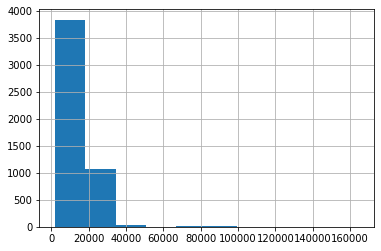

In [48]:
my_submission['y'].hist()

In [49]:
my_submission.to_csv(os.path.join(OUTPUT_DIR, f'submission_{RESULT["No"]}.csv'), index=False)

In [50]:
RESULT['Fold'] = FOLD
with open(os.path.join(OUTPUT_DIR, 'result.json'), 'w') as f:
    json.dump(RESULT, f)